- Lihua Xiong, lx559

# Homework Probelm 1: LSA-based Recommender

**Preparation:**
- Work off of the LSA notebook that we went through in class
- Download the Reuters data from Chris McCormick's github repo https://github.com/chrisjmccormick/LSA_Classification
    - Make sure the code in this notebook runs against the raw_text_dataset.pickle in the github repo
    - assume that the dataset PATH is in the same directory as where the notebook is so that our grader Yifei can run your notebook with his own copy of the dataset in the same folder
    - also feel free to modify this current notebook so as to complete the rest of the problem below:


**Step 1:**
- Create a doc2vec(doc, tfidf_vectorizer) function corresponding to a TFIDF vec
    - INPUTS: doc, tfidf_vectorizer
        - doc - any string
        - tfidf_vectorizer - a TfidfVectorizer instance
    - OUTPUTS: vec, doc_features, doc_counts
        - vec - a vector with $L_2$ norm of $1$
        - doc_features - the features after tokenization and pre-processing
        - doc_counts - the counts of each feature in this document
    - note that you should not normalize by the inverse document frequency as there is just a single document

In [10]:
import pickle
import os
import time

import numpy as np
import scipy.sparse as sparse
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# load the corpus
fname = "raw_text_dataset.pickle"
filepath = os.getcwd() + '/' + fname
raw_text_dataset = pickle.load(open(filepath, "rb"))

In [12]:
# the training corpus for the input tfidf_vectorizer, which contains 4743 documents.
X_train_raw = raw_text_dataset[0]
len(X_train_raw)

4743

In [13]:
# train the tfidf_vectorizer
vectorizer = TfidfVectorizer(
    max_df=0.5, # ignore terms which occur in more than half of the documents
    max_features=10000,
    min_df=2, # ignore terms which occur in less than 2 documents
    stop_words='english',
    norm='l2',
    use_idf=True, 
    analyzer='word',
#     token_pattern='(?u)\\b\\w\\w+\\b'
    token_pattern = '(?u)\\b[a-zA-Z]\\w+\\b'
    )

# note how changing the token_pattern changes
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
print(X_train_tfidf.shape)
print('first 10 features:', vectorizer.get_feature_names()[:10])
print('last 10 features:', vectorizer.get_feature_names()[-10:])

(4743, 10000)
first 10 features: ['a300', 'a330', 'a340', 'aa', 'aaa', 'aapl', 'ab', 'abandon', 'abandoned', 'abandonment']
last 10 features: ['zinc', 'zntl', 'zoete', 'zone', 'zones', 'zorinsky', 'zortman', 'zuckerman', 'zurich', 'zy']


In [19]:
def doc2vec(doc, tfidf_vectorizer, debug=False):
    # We can represent any new document in terms of our previous model
    #doc_vectorizer = tfidf_vectorizer
    doc_vectorizer = clone(tfidf_vectorizer)
    # here we only use it for one input corpus so we need to change these two params
    doc_vectorizer.max_df = 1.0
    doc_vectorizer.min_df = 1.0
    doc_corpus = [doc]
    X_docterm = doc_vectorizer.fit_transform(doc_corpus)
    doc_features = doc_vectorizer.get_feature_names()
    doc_counts = X_docterm.toarray()[0]
    
    # Here we ignore the features that are not contained in the original tfidf_vectorizer
    features = [feature for feature in doc_features if feature in tfidf_vectorizer.vocabulary_]
    nonzero_idx = [tfidf_vectorizer.vocabulary_.get(feature) for feature in features]
    new_doc_counts = [doc_counts[doc_vectorizer.vocabulary_.get(feature)] for feature in features]
    
    if debug:
        print(features, new_doc_counts)
        
    vec = sparse.coo_matrix(
        (new_doc_counts, (np.zeros_like(new_doc_counts), nonzero_idx)),
        shape=(1, len(tfidf_vectorizer.get_feature_names())))
    return vec, doc_features, doc_counts

**Step 2:**
- For each of the following doc strings, calculate their corresponding vectors
    - doc1: "The cocoa cadabra"
    - doc2: "AAPL SE"
    - doc3: "bullish stocks"

In [20]:
doc1 = 'The cocoa cadabra'
doc2 = 'AAPL SE'
doc3 = 'bullish stocks'

**Note:** In doc1, the word "cadabra" doesn't exist in the original vectorizer. In the function above, we only discard the new feature without re-normalizing the weight.

In [21]:
v1,_,_ = doc2vec(doc1, vectorizer, debug=True)
v1, v1.toarray()

['cocoa'] [0.70710678118654746]


(<1x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in COOrdinate format>,
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [22]:
v2,_,_ = doc2vec(doc2, vectorizer, debug=True)
v2, v2.toarray()

['aapl', 'se'] [0.70710678118654746, 0.70710678118654746]


(<1x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in COOrdinate format>,
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [37]:
v3,_,_ = doc2vec(doc3, vectorizer, debug=True)
v3, v3.toarray()

['bullish', 'stocks'] [0.70710678118654746, 0.70710678118654746]


(<1x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in COOrdinate format>,
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

**Step 3:**
- Create a **recommend(vec, X_model, X_corpus)** function:
    - which projects any document vector onto X_model
        - here X_model = {X_train_tfidf, and X_train_lsa}
    - and returns doc_vec, idx_top10, sim_top10, X_top10 as follows
        - doc_vec - the (sparse) vector of similarity scores of vec and members of X_model. 
        This vector should be size (Dx1)
        - idx_top10: the indices of the top-10 similarity scores
        - sim_top10: the top-10 similarity scores
        - X_top10: the top-10 corpus articles most similar to the input model
    - what does your recommend() function ouput for the doc vectors in the previous exersise?
        - Do you see an improvement of the LSA similarity recommendation relative to the TF-IDF similarity recommendation?

In [24]:
# Project the tfidf vectors onto the first N principal components.
# Though this is significantly fewer features than the original tfidf vector,
# they are stronger features, and the accuracy is higher.
svd = TruncatedSVD(
    n_components=200,
    random_state=42,
    algorithm='arpack'
)

lsa = make_pipeline(
    svd, 
#    Normalizer(copy=False) # try commenting this out. Do you get a better result?  No.
)

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
def recommend(doc, X_model, X_corpus):
    # the vectorizer was trained outside of this function 
    vec,_,_ = doc2vec(doc, vectorizer)
    vec = vec.toarray()
    # For LSA
    if type(X_model) == np.ndarray:
        # we need to transform the vector first!! i.e. perform the same dimensional reduction
        vec_new = lsa.transform(vec)
        doc_vec = cosine_similarity(vec_new,X_model)[0]
    else: # for tfidf
        doc_vec = cosine_similarity(vec,X_model.toarray())[0]
        
    # top 10 descending order
    idx_top10 = np.argsort(-doc_vec)[:10]
    sim_top10 = doc_vec[idx_top10]
    # convert list to np.array
    X_corpus = np.array(X_corpus)
    X_top10 = X_corpus[idx_top10]
    
    return doc_vec,idx_top10, sim_top10, X_top10

**Test:**

**1.** Test it on doc1 = 'The cocoa cadabra' using X_train_tfidf model.

In [27]:
doc_vec_1, idx_top10_1, sim_top10_1, X_top10_1 = recommend(doc1, X_train_tfidf, X_train_raw)

Observe the outputs as below.

In [28]:
doc_vec_1

array([ 0.35255483,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [29]:
idx_top10_1

array([3009, 2974,    0,  266, 3917, 3092, 2318, 4232, 1720, 4322])

In [30]:
sim_top10_1

array([ 0.42235728,  0.42040369,  0.35255483,  0.35085335,  0.2988182 ,
        0.14068797,  0.11826212,  0.1143153 ,  0.10724859,  0.05619974])

The most similar document.

In [45]:
X_top10_1[0]

'GHANA COCOA PURCHASES FALL, CUMULATIVE STILL UP\n\nThe Ghana Cocoa Board said it purchased 1,323 tonnes of cocoa in the 21st week, ended February 26, of the 1986/87 main crop season, compared with 1,961 tonnes the previous week and 1,344 tonnes in the 21st week ended March six of the 1985/86 season, the board said. Cumulative purchases so far this season stand at 216,095 tonnes, still up on the 201,966 tonnes purchased by the 21st week of last season, the Board said. Reuter '

**2.** Test it on doc1 = 'The cocoa cadabra' using X_train_lsa model.

In [40]:
doc_vec_2, idx_top10_2, sim_top10_2, X_top10_2 = recommend(doc1, X_train_lsa, X_train_raw)

Observe the outputs as below.

First, the doc_vec is more condensed than that of the tfidf model.

In [41]:
doc_vec_2

array([ 0.37158756, -0.03656637, -0.03353612, ...,  0.04979113,
        0.00725443,  0.00534638])

The top 10 similar ids are partially different.

In [42]:
idx_top10_2

array([3009, 2974,  266, 3833,  894,  220, 3917, 1741, 3339, 2867])

The absolute value of top 10 cosine similarity is higher.

In [43]:
sim_top10_2

array([ 0.66299725,  0.63583877,  0.58200046,  0.51773392,  0.49465865,
        0.47773937,  0.46553139,  0.44976251,  0.44355088,  0.43288301])

The most similar document is the same.

In [52]:
X_top10_2[0]

'GHANA COCOA PURCHASES FALL, CUMULATIVE STILL UP\n\nThe Ghana Cocoa Board said it purchased 1,323 tonnes of cocoa in the 21st week, ended February 26, of the 1986/87 main crop season, compared with 1,961 tonnes the previous week and 1,344 tonnes in the 21st week ended March six of the 1985/86 season, the board said. Cumulative purchases so far this season stand at 216,095 tonnes, still up on the 201,966 tonnes purchased by the 21st week of last season, the Board said. Reuter '

**Conclusion:**

As we could see above, LSA gave us different results from the original one. And obviously the cosine similarity look better (more condensed) than the previous one. But whether it's qualified as an "improvement" may need other assessing metrics and more testing documents.

# Homework Problem 2: Independent Component Analysis

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

In [55]:
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

**Question 1:**
- What happens when you add a gaussian noise component s4 in the code above?
    - Can you recover the True source signals when you let n_components=4? If yes, why yes? If no, why not?
    - Can you recover the True source signals when you let n_components=3? If yes, why yes? If no, why not?

In [68]:
s4 = np.random.normal(size=n_samples)

S1 = np.c_[s1, s2, s3, s4]
S1 += 0.2 * np.random.normal(size=S1.shape)  # Add noise

S1 /= S1.std(axis=0)  # Standardize data

# Mix data
A1 = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 1.5], [1.5, 1.0, 2.0, 0.5], [2.0, 0.5, 1.0, 2.0]])  # Mixing matrix
X1 = np.dot(S1, A1.T)  # Generate observations

**1.** Let n_components = 4.

In [71]:
# Compute ICA
ica1 = FastICA(n_components=4)
S1_ = ica1.fit_transform(X1)  # Reconstruct signals
A1_ = ica1.mixing_  # Get estimated mixing matrix

# For comparison, compute PCA
pca1 = PCA(n_components=4)
H1 = pca1.fit_transform(X1)  # Reconstruct signals based on orthogonal components

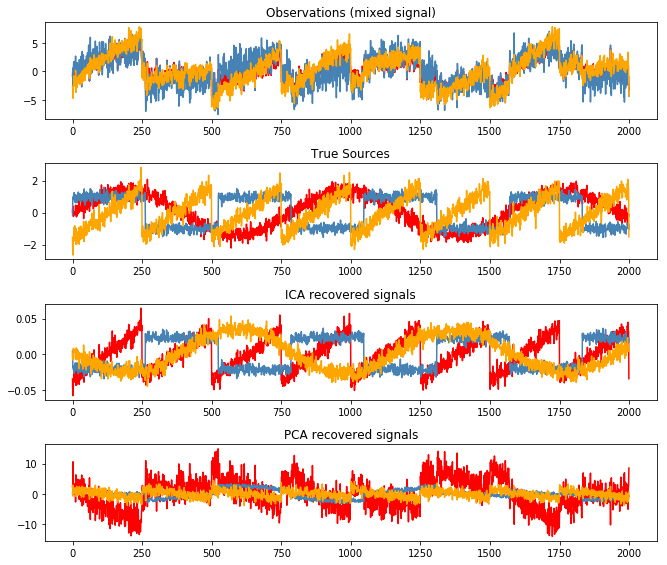

In [79]:
# #############################################################################
# Plot results

plt.figure(figsize=(10,8))

models = [X1, S1, S1_, H1]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
# Note!!!! Here the colors correspond to each signal.
# Here we only examine the first 3.
colors = ['red', 'steelblue', 'orange']
#colors = ['red', 'steelblue', 'orange', 'gray']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

**Conclusion:**

ICA still recovers the signal, because the **independent** Gaussian variable contains the least information (kurtosis is 0), which doesn't affect the optimization problem. 

**2.** Let n_components = 3.

In [80]:
# Compute ICA
ica1 = FastICA(n_components=3)
S1_ = ica1.fit_transform(X1)  # Reconstruct signals
A1_ = ica1.mixing_  # Get estimated mixing matrix

# For comparison, compute PCA
pca1 = PCA(n_components=3)
H1 = pca1.fit_transform(X1)  # Reconstruct signals based on orthogonal components

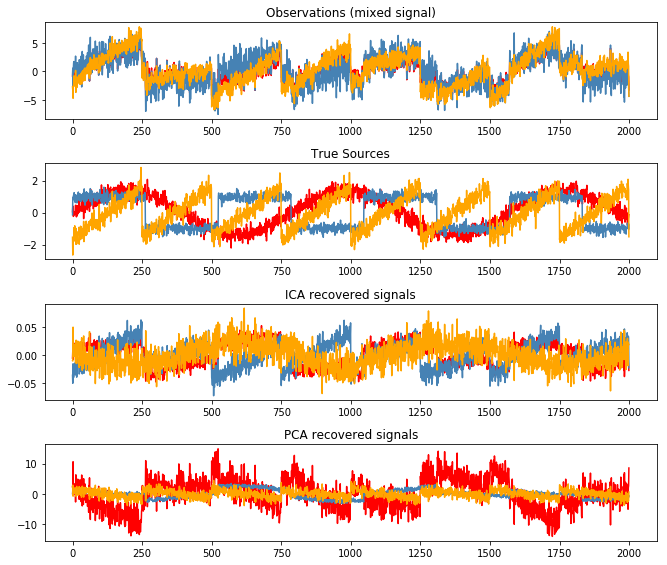

In [94]:
# #############################################################################
# Plot results

plt.figure(figsize=(10,8))

models = [X1, S1, S1_, H1]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
# Note!!!! Here the colors correspond to each signal.
# Here we could comment and uncomment to compare the result!!!
colors = ['red', 'steelblue', 'orange']
#colors = ['red', 'steelblue', 'orange', 'gray']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

**Conclusion:**

By setting n_component = 3, ICA couldn't recover the signal, because it's essentially combining 2 true **independent** and **different** signals into 1, which solves a wrong optimization problem. As is shown above, the saw_tooth signal is mixed with Gaussian.

**Question 2:**
- What happens when you add two gaussian noise components s4 and s5 in the code above?
    - Can you recover the True source signals when you let n_components=5? If yes, why yes? If no, why not?
    - Can you recover the True source signals when you let n_components=4? If yes, why yes? If no, why not?

In [100]:
s5 = np.random.normal(size=n_samples)

S2 = np.c_[s1, s2, s3, s4, s5]
S2 += 0.2 * np.random.normal(size=S2.shape)  # Add noise

S2 /= S2.std(axis=0)  # Standardize data

# Mix data
A2 = np.array([[1, 1, 1, 1, 1], [0.5, 2, 1.0, 1.5, 1.5], [1.5, 1.0, 2.0, 0.5, 0.5], [2.0, 0.5, 1.0, 2.0, 2.0], [0.5, 0.5, 1.0, 1.5, 2.0]])  # Mixing matrix
X2 = np.dot(S2, A2.T)  # Generate observations

**1.** Let n_component = 5.

In [105]:
# Compute ICA
ica2 = FastICA(n_components=5)
S2_ = ica2.fit_transform(X2)  # Reconstruct signals
A2_ = ica2.mixing_  # Get estimated mixing matrix

# For comparison, compute PCA
pca2 = PCA(n_components=5)
H2 = pca2.fit_transform(X2)  # Reconstruct signals based on orthogonal components

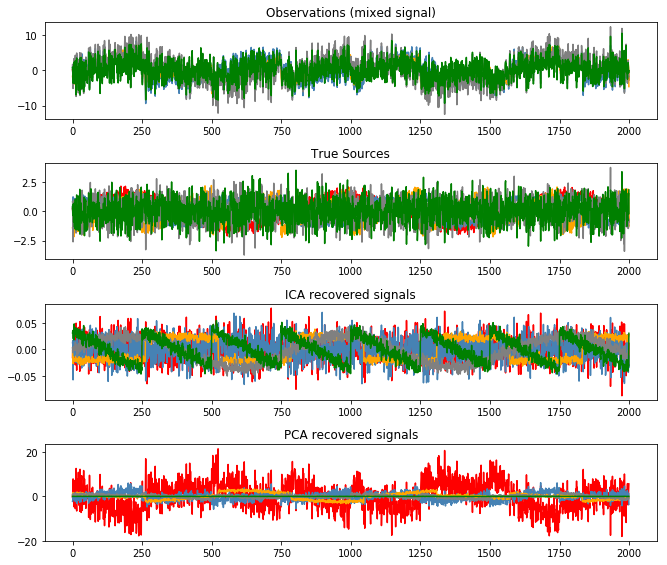

In [110]:
# #############################################################################
# Plot results

plt.figure(figsize=(10,8))

models = [X2, S2, S2_, H2]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
# Note!!!! Here the colors correspond to each signal.
# We could comment and uncomment to compare results.
#colors = ['red', 'steelblue', 'orange']
#colors = ['red', 'steelblue', 'orange', 'gray']
colors = ['red', 'steelblue', 'orange', 'gray', 'green']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

**Conclusion:**
As is shown above, the true signals are recovered, because s4 and s5 are independent Gaussian with kurtosis 0.

**2.** Let n_component = 4.

In [111]:
# Compute ICA
ica2 = FastICA(n_components=4)
S2_ = ica2.fit_transform(X2)  # Reconstruct signals
A2_ = ica2.mixing_  # Get estimated mixing matrix

# For comparison, compute PCA
pca2 = PCA(n_components=4)
H2 = pca2.fit_transform(X2)  # Reconstruct signals based on orthogonal components

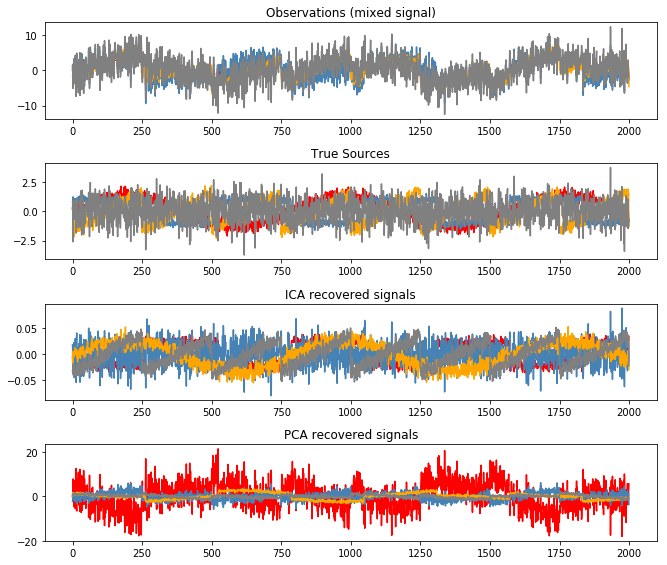

In [121]:
# #############################################################################
# Plot results

plt.figure(figsize=(10,8))

models = [X2, S2, S2_, H2]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
# Note!!!! Here the colors correspond to each signal.
# Here we could comment and uncomment to examine results.
#colors = ['red']
#colors = ['red', 'steelblue']
#colors = ['red', 'steelblue', 'orange']
colors = ['red', 'steelblue', 'orange', 'gray']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

**Conclusion:**

As is shown above, the signals are still recovered by ICA. This is because two independent Gaussian signals are combined (since they both contain the least information) as one Gaussian signal (which still is kurtosis 0) and they don't affect other signals that contain significantly more information.